## Input Analysis

In [4]:
import numpy as np
import scipy.stats as st
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None


data = pd.read_csv('TonerItDown.csv')
data = data[data['Time of day']<24]
n = len(data)

#Create rate table for Request generation
emp_rate = data.groupby(data['Time of day'].apply(np.floor)).size() / 60
emp_rate = emp_rate.values
coeffs = np.polyfit(np.arange(3,22),emp_rate[3:22],deg = 2)
fitted_rate = np.zeros(24)
fitted_rate[3:22] = coeffs[0]*np.arange(3,22) ** 2 + coeffs[1]*np.arange(3,22) + coeffs[2]
fitted_rate[[0,1,2,22,23]] = np.mean(emp_rate[[0,1,2,22,23]])
rates = pd.DataFrame(data = fitted_rate,columns = ['fitted rate'])


#Paramaters for Initial Diagnosis Time fitted to the normal distribution 
param_diagnose_a = st.norm.fit(data[data['Request location'].isin
                         (['BC_1','BC_10','BC_4','BC_5','BC_6','BC_7','BC_8'])]['Initial diagnose time'])
param_diagnose_b = st.norm.fit(data[data['Request location'].isin(['BC_2','BC_3','BC_9'])]
                               ['Initial diagnose time'])


# Paramaters for the beta distribution fit for Onsite Repair Time
data_on_site = data['On-site repair time'][data['Needs Replacement?'] != 'yes']
n_on_site = len(data_on_site)
params_repair_beta = st.beta.fit(data_on_site)


#Empirical Probabilities of a call orginating at a BC
p_hat = data.groupby(by = 'Request location')['Initial diagnose time'].size() / n
std = np.sqrt(p_hat * (1-p_hat))
probabilities = p_hat.values.tolist()


# Create Python objects from data given in problem specification
Distances = {
            "BC1":{"BC1": 0,"BC2": 20,"BC3": 30,"BC4": 45,"BC5": 50,"BC6": 50,"BC7": 60,"BC8": 55,"BC9": 60,"BC10": 70,"Dispatch":45},
            "BC2":{"BC2": 0,"BC1": 20,"BC3": 10,"BC4": 25,"BC5": 30,"BC6": 50,"BC7": 60,"BC8": 55,"BC9": 60,"BC10": 70,"Dispatch": 45},
            "BC3":{"BC3": 0,"BC1": 30,"BC2": 10,"BC4": 15,"BC5": 20,"BC6": 40,"BC7": 50,"BC8": 45,"BC9": 50,"BC10": 60,"Dispatch": 35},
            "BC4":{"BC4": 0,"BC1": 45,"BC2": 25,"BC3": 15,"BC5": 5 ,"BC6": 55,"BC7": 65,"BC8": 60,"BC9": 65,"BC10": 75,"Dispatch": 50},
            "BC5":{"BC5": 0,"BC1": 50,"BC2": 30,"BC3": 20,"BC4": 5 ,"BC6": 60,"BC7": 70,"BC8": 65,"BC9": 70,"BC10": 80,"Dispatch": 55},
            "BC6":{"BC6": 0,"BC1": 50,"BC2": 50,"BC3": 40,"BC4": 55,"BC5": 60,"BC7": 10,"BC8": 5 ,"BC9": 10,"BC10": 20,"Dispatch": 25},
            "BC7":{"BC7": 0,"BC1": 60,"BC2": 60,"BC3": 50,"BC4": 65,"BC5": 70,"BC6": 10,"BC8": 15,"BC9": 20,"BC10": 10,"Dispatch": 35},
            "BC8":{"BC8": 0,"BC1": 55,"BC2": 55,"BC3": 45,"BC4": 60,"BC5": 65,"BC6": 5 ,"BC7": 15,"BC9": 5 ,"BC10": 15,"Dispatch": 30},
            "BC9":{"BC9": 0,"BC1": 60,"BC2": 60,"BC3": 50,"BC4": 65,"BC5": 70,"BC6": 10,"BC7": 20,"BC8": 5 ,"BC10": 10,"Dispatch": 35},
            "BC10":{"BC10": 0,"BC1":70,"BC2": 70,"BC3": 60,"BC4": 75,"BC5": 80,"BC6": 20,"BC7": 10,"BC8": 15,"BC9" : 10,"Dispatch": 45}}

BusinessCenters = ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6", "BC7", "BC8", "BC9", "BC10"]

/home/jackson/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [67]:
class Request:
    def __init__(self, initialized_time):
        """Initialize Random location and Random interarival time for Request"""
        self.loc = np.random.choice(BusinessCenters,1,p=probabilities)[0]
        self.status = "Waiting"
        self.initialized_time = initialized_time + dt.timedelta(minutes=
                int(np.random.poisson((1 / rates[rates.index == initialized_time.hour]['fitted rate'] * 60), 1)[0]))
        self.times = [self.initialized_time]
        self.assigned_mechanic = None
        self.assigned_van = None
        
    def add_travel_time_mech(self, now) :
        """Time to travel from assigned mechanic's location to request's location"""
        self.times.append(now + dt.timedelta(minutes=Distances[self.loc][self.assigned_mechanic.loc]))
       
    def gen_diagnose_time(self,now):
        """Generate Time for Mechanic to diagnose the problem...distribution dependent on BC"""
        if self.loc in ['BC_2','BC_3','BC_9']:
            self.times.append(now + dt.timedelta(minutes=np.random.normal(param_diagnose_b[0], param_diagnose_b[1])))
        else: 
            self.times.append(now + dt.timedelta(minutes=np.random.normal(param_diagnose_a[0], param_diagnose_a[1])))
        
    def update_status(self):
        """Generate wether or not this can be repaired onsite"""
        self.status = np.random.choice(["Onsite","Replace"],1,p=[.8195, .1805])[0] # fix these probs
          
    def gen_onsite_repair_time(self,now):
        """Generate time for Mechanic to repair copier onsite from beta distribution fit"""
        self.times.append(now + dt.timedelta(minutes = np.random.beta(params_repair_beta[0], params_repair_beta[1])))        

    def add_travel_time_van(self, now) :
        """Time to travel from assigned van's location to request's location"""
        self.times.append(now + dt.timedelta(minutes=Distances[self.loc]["Dispatch"]))
    
    def gen_van_replace_time(self, now) :
        """Generate time for Van to replace broken copier with new one at BC"""
        self.times.append(now + dt.timedelta(minutes= np.random.triangular(20,30,60)))
            

class Van:
    def __init__(self, id, time):
        """Initialize Van with free time at start of simulation, location at Dispatch"""
        self.id = id
        self.free_time = time
        self.free_period = []
        
        
    def update_free_time(self, now, BC):
        """Set the Van to be free in the time it takes from now to return from dispatch and load a new copier"""
        self.free_time = now + dt.timedelta(minutes= Distances[BC]['Dispatch']) +dt.timedelta(
                                            minutes= np.random.triangular(10,15,25)) 
                             
class Mechanic:
    def __init__(self, id, time):
        """Initialize Mechanic with free time at start of simulation, location at Dispatch"""
        self.loc = 'Dispatch'
        self.id = id
        self.free_time = time
        self.free_period = []

In [91]:
def get_worker(workers, loc, time, isMech):
    """Returns the closest/next available worker who can process request and the time they begin processing"""
    w = None     # Worker we will assign
    free = []    # List of free workers
    t = time     # Time the worker will be able to begin handling request 
    
    # Find all free workers
    for worker in workers:
        if (worker.free_time < time): 
            free.append(worker)
       
    # Find closest free mechanic/any free van, and add the period they were free to their free_period list
    if(free):
        w = free[0]
        if(isMech): 
            for worker in free:
                if(Distances[loc][worker.loc] < Distances[loc][w.loc]): w = worker
        w.free_period.append((time, w.free_time))
    
    # Otherwise, find next free worker, and update the time to the time they are free
    if(w is None):
        w = workers[0]
        for worker in workers:
            if(worker.free_time < w.free_time): 
                w = worker
                t = worker.free_time
    return w, t
              

def simulate(max_m, max_v, n_reqs):
    """
    Run Simulaton with n_mech mechanics and n_van vans and n_req requests, return dataframes for both
    repair times and replace time
    """
    response_times, replace_times = [], []
    n_mech = 1
    while(n_mech <= max_m):
        n_van =1
        while(n_van <= max_v):
            # Initialize the Simulation Run
            time = dt.datetime.now()
            sim_list, mechanics, vans = [], [], []
            for m in range(0, n_mech): 
                mechanics.append(Mechanic(m, time))
            for v in range(0, n_van): 
                vans.append(Van(v, time))
            for s in range(0, n_reqs):
                sim_list.append(Request(time))
                time = sim_list[-1].initialized_time

            #Run Simulation
            for req in sim_list:
                time = req.initialized_time
                req.assigned_mechanic, time = get_worker(mechanics, req.loc, time, True)
                req.add_travel_time_mech(time)                       
                req.assigned_mechanic.loc = req.loc  
                time = req.times[-1]                                
                req.gen_diagnose_time(time)
                time = req.times[-1]
                req.update_status()
                if(req.status == "Onsite"):
                    req.gen_onsite_repair_time(time)
                    req.assigned_mechanic.free_time = req.times[-1]
                else:
                    req.assigned_mechanic.free_time = req.times[-1]
                    req.assigned_van, time = get_worker(vans, req.loc, time, False)
                    req.add_travel_time_van(time)
                    time = req.times[-1]
                    req.gen_van_replace_time(time)
                    time = req.times[-1]
                    req.assigned_van.update_free_time(time, req.loc)

            # Calculate Request Process Times
            df = pd.DataFrame([y.times for y in sim_list])
            df['n_vans'] = n_van
            df['n_mechanics'] = n_mech
            df['Response'] = df[2] - df[0]
            df['Status'] = pd.DataFrame([y.status for y in sim_list])
            df_replace = df[df['Status'] == 'Replace']
            df_replace['Replace'] = df_replace[4] - df_replace[0]

            # Calculate Worker Utilization
            total_time = (time - sim_list[0].initialized_time).total_seconds()
            m_util, v_util = [], []
            for m in mechanics:
                tmp = dt.timedelta(minutes=0)
                for pair in m.free_period:
                    tmp += (min(pair[0], time) - pair[1])
                m_util.append(tmp.total_seconds() / total_time)
            m_util = 1 - np.mean(m_util)
            for v in vans:
                tmp = dt.timedelta(minutes=0)
                for pair in v.free_period:
                    tmp += (min(pair[0], time) - pair[1])
                v_util.append(tmp.total_seconds() / total_time)
            v_util = 1 - np.mean(v_util)
            
            # Append Data from Simulation Run
            response_times.append([n_mech, n_van, df['Response'].mean().total_seconds()/60, m_util, v_util])
            replace_times.append([n_mech, n_van, df_replace['Replace'].mean().total_seconds()/60])

            n_van += 1 # Inceremnt Vans
            
        n_mech += 1 # Increment Mechanics
        
    response = pd.DataFrame(response_times, 
                            columns=['Mechanics', 'Vans', 'Response_Time', 'Mech_Utilization', 'Van_Utilization'])
    replace = pd.DataFrame(replace_times, columns=['Mechanics', 'Vans', 'Replace_Time'])
    return response, replace

In [ ]:
response, replace = simulate(10,10, 10000)
response[response['Mechanics'] == 5]

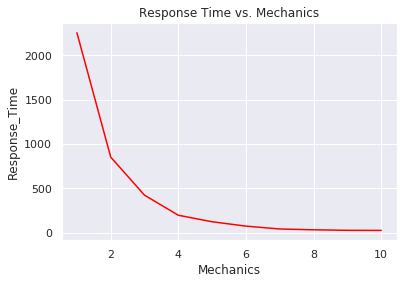

In [75]:
sns.set()
groups = response.groupby('Mechanics').mean()
pl = sns.lineplot(groups.index, groups['Response_Time'], color='red').set_title("Response Time vs. Mechanics")
pl.get_figure().savefig("ResponsevMechanic.jpeg")

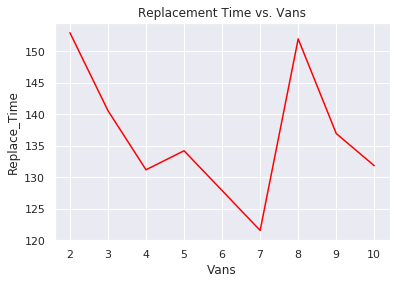

In [94]:
r = replace[replace['Mechanics'] == 5]
r = r[r['Vans']>1]
pl = sns.lineplot(r['Vans'], r['Replace_Time'], color='red').set_title('Replacement Time vs. Vans')
pl.get_figure().savefig("ReplaceVan.png")

In [58]:
r.groupby("Vans").mean()

,Mechanics,Replace_Time
Vans,,
2,5,222.516786
3,5,195.932609
4,5,204.252216
5,5,209.197816
6,5,120.142729
7,5,162.683652
8,5,193.854761
9,5,238.060741
10,5,200.339396


In [34]:
def simulate_shift(max_m, max_v, begin_hr, end_hr, warmup_hrs):
    """
    Run Simulaton with n_mech mechanics and n_van vans and n_req requests, return dataframes for both
    repair times and replace time
    """
    response_times, replace_times = [], []
    n_mech = 1
    while(n_mech <= max_m):
        n_van =1
        while(n_mech <= max_v):
            # Initialize the Simulation Run
            time = dt.datetime.combine(dt.today(), dt.time(begin_hr - warmup_hrs, 0))
            max_t = dt.datetime.combine(dt.today(), dt.time(end_hr, 0))
            sim_list, mechanics, vans = [], [], []
            for m in range(0, n_mech): 
                mechanics.append(Mechanic(m, time))
            for v in range(0, n_van): 
                vans.append(Van(v, time))
            while(time < max_t):
                req = Request(time)
                t = dt.datetime.combine(dt.today(), dt.time(begin_hr, 0))
                if(req.initialized_time > t): sim_list.append(req)
                time = sim_list[-1].initialized_time
            
            #Run Simulation
            for req in sim_list:
                time = req.initialized_time
                if time.hour
                req.assigned_mechanic, delay = get_worker(mechanics, req.loc, time) 
                if delay is not None: time = delay                    
                req.add_travel_time_mech(time)                       
                req.assigned_mechanic.loc = req.loc                   
                time = req.times[-1]                                
                req.gen_diagnose_time(time)
                time = req.times[-1]
                req.update_status()
                if(req.status == "Onsite"):
                    req.gen_onsite_repair_time(time)
                    req.assigned_mechanic.free_time = req.times[-1]
                else:
                    req.assigned_van, delay = get_worker(vans, req.loc, time)
                    if delay is not None: time = delay
                    req.add_travel_time_van(time)
                    req.assigned_van.loc = req.loc
                    time = req.times[-1]
                    req.gen_van_replace_time(time)
                    time = req.times[-1]
                    req.assigned_van.update_free_time(time)
                    req.assigned_van.loc = 'Dispatch'

            # Calculate Request Process Times
            df = pd.DataFrame([y.times for y in sim_list])
            df['n_vans'] = n_van
            df['n_mechanics'] = n_mech
            df['Response'] = df[2]-df[0]
            df['Status'] = pd.DataFrame([y.status for y in sim_list])
            df_replace = df[df['Status'] == 'Replace']
            df_replace['Replace'] = df_replace[3] - df_replace[2]
            
            # Calculate Worker Utilization
            total_time = time - sim_list[0].initialized_time
            m_util, v_util = [], []
            for m in mechanics:
                m.utilization_calc(total_time)
                m_util.append(m.utilization)
            for v in vans:
                v.utilization_calc(total_time)
                v_util.append(v.utilization)
            m_util = np.mean(m_util)
            v_util = np.mean(v_util)
            
            # Append Data from Simulation Run
            response_times.append([n_mech, n_van, df['Response'].mean().total_seconds()/60, m_util, v_util])
            replace_times.append([n_mech, n_van, df_replace['Replace'].mean().total_seconds()/60])
            
            n_van += 1 # Inceremnt Vans
            
        n_mech += 1 # Increment Mechancis
        
    response = pd.DataFrame(response_times, 
                            columns=['Mechanics', 'Vans', 'Response_Time', 'Mech_Utilization', 'Van_Utilization'])
    replace = pd.DataFrame(replace_times, columns=['Mechanics', 'Vans', 'Replace_Time'])
    return response, replace

/home/jackson/.local/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3477964.147037
3528731.787629
3480095.057543
3533845.12725
3552024.384294
3541268.845946
3532600.467709
3642221.981224
3543302.76508
3627851.083855
3544343.461866
3549678.417367
3532309.558982
3542423.884129
3570302.029219
3558029.466033
3530846.405676
3560397.092953
3555289.864153
3640120.278541
3567480.423677
3615140.65585
3499366.071736
3554816.088658
3553141.270022
3564321.354616
3586876.252594
3553146.161076
3482432.337639
3557105.795891
3546479.793924
3541868.170968
3557288.579469
3553012.468947
3550271.280469
3545009.868915
3552144.050272
3444401.98666
3475607.826812
3590645.860607
3549613.05994
3616390.288076
3570702.029867
3549966.315885
3617350.430599
3583534.658788
3548092.134996
3554577.477852
3568302.068609
3531898.833271
3544058.574841
3573006.774239
3551525.155723
3466628.031721
3560074.100253
3479144.129205
3496498.94076
3540849.303738
3557241.57153
3638724.809296
3633424.167007
3617521.669489
3551957.869822
3645361.901359
3568609.270609
3560288.978176
3638962.118703
35

(    Mechanics  Vans  Response_Time  Mech_Utilization  Van_Utilization
 0           1     1      41.520974          0.726825         0.908718
 1           1     2      38.891330          0.742353        12.559273
 2           1     3      42.523437          0.725640        10.254493
 3           1     4      39.459362          0.739598         7.035560
 4           1     5      41.377927          0.728485         4.096860
 ..        ...   ...            ...               ...              ...
 95         10     6       7.583333         15.215060         4.283931
 96         10     7       9.116667         15.052442         4.184668
 97         10     8      10.700000         15.203261         3.864512
 98         10     9       6.166667         15.145700         3.338263
 99         10    10       8.750000         15.177058         2.504502
 
 [100 rows x 5 columns],     Mechanics  Vans  Replace_Time
 0           1     1     99.226744
 1           1     2     98.108932
 2           1   